# Overlay Analysis

## Overview of Progress and Context

The study has progressed through habitat suitability modelling (SDM), ensemble modelling, and connectivity modelling to assess amphibian movement potential across Central Scotland. Initial findings from the SDMs indicated a bias toward urban areas, likely driven by survey effort distribution. To address this, an alternative approach was used to generate resistance surfaces based on expert-derived classifications of land cover, rather than relying solely on habitat suitability outputs. Connectivity analyses using Circuitscape have been conducted with different resistance scaling methods, including inverse scaling and logarithmic transformations, to assess their impact on corridor identification.

The next step involves mapping Blue-Green Infrastructure (BGI) opportunities by intersecting connectivity outputs with urban features. The goal is to identify locations where interventions, such as habitat restoration or the creation of amphibian-friendly corridors, could enhance ecological connectivity. This phase builds on the methodology from Donati et al. (2022) and follows the approach outlined in the connectivity modelling section of the study.

### Step 1: Standardization of Connectivity Maps
Before performing any overlay analysis, connectivity maps need to be standardized to ensure consistency across species and resistance models.

In [1]:
import rasterio
import numpy as np
import geopandas as gpd
from rasterio.features import shapes
import fiona

# Function to normalize raster
def normalize_raster(input_raster, output_raster):
    with rasterio.open(input_raster) as src:
        data = src.read(1).astype(float)
        data[data == src.nodata] = np.nan
        min_val = np.nanmin(data)
        max_val = np.nanmax(data)
        norm_data = (data - min_val) / (max_val - min_val)
        
        profile = src.profile
        profile.update(dtype=rasterio.float32)
    
    with rasterio.open(output_raster, 'w', **profile) as dst:
        dst.write(norm_data.astype(np.float32), 1)

# Paths to rasters
rasters = {
    "Bufo": "C:/GIS_Course/MScThesis-MaviSantarelli/results/Circuitscape_Results/BufoFiltered/Bufo_Exponential_output_cum_curmap.asc"}

# Normalize each raster
for species, raster_path in rasters.items():
    output_path = raster_path.replace(".asc", "_norm.tif")
    normalize_raster(raster_path, output_path)
    print(f"Normalized raster saved: {output_path}")


Normalized raster saved: C:/GIS_Course/MScThesis-MaviSantarelli/results/Circuitscape_Results/BufoFiltered/Bufo_Exponential_output_cum_curmap_norm.tif


### Step 2: Binarization of Connectivity Corridors

Following Donati et al. (2022), corridors will be identified using the 90th percentile threshold.

#### 1. Compute the 90th percentile threshold:

In [2]:
def compute_threshold(raster_path):
    with rasterio.open(raster_path) as src:
        data = src.read(1)
        threshold = np.nanpercentile(data, 90)
    return threshold

def binarize_raster(input_raster, output_raster, threshold):
    with rasterio.open(input_raster) as src:
        data = src.read(1)
        binary_data = (data >= threshold).astype(np.uint8)
        
        profile = src.profile
        profile.update(dtype=rasterio.uint8)
    
    with rasterio.open(output_raster, 'w', **profile) as dst:
        dst.write(binary_data, 1)

#### 2. Apply binarization to create corridor maps (1 = key corridor, 0 = background):

In [3]:
# Apply binarization
for species, raster_path in rasters.items():
    norm_raster = raster_path.replace(".asc", "_norm.tif")
    threshold = compute_threshold(norm_raster)
    binarized_output = raster_path.replace(".asc", "_binary.tif")
    binarize_raster(norm_raster, binarized_output, threshold)
    print(f"Binarized raster saved: {binarized_output}")

Binarized raster saved: C:/GIS_Course/MScThesis-MaviSantarelli/results/Circuitscape_Results/BufoFiltered/Bufo_Exponential_output_cum_curmap_binary.tif


### Step 3: Overlay Analysis with Urban Features

To assess the overlap between connectivity corridors and urban features (e.g., roads, parks, impervious surfaces), spatial overlay analysis is required.

#### 1. Load urban feature layers (e.g., roads, green spaces) as vector data:

In [4]:
import geopandas as gpd

# Reload without reprojection
green_areas = gpd.read_file(r"C:/GIS_Course/MScThesis-MaviSantarelli/data/OSM/GreenAreas.shp")
grey_areas = gpd.read_file(r"C:/GIS_Course/MScThesis-MaviSantarelli/data/OSM/GreyAreas.shp")
grey_areas_lines = gpd.read_file(r"C:/GIS_Course/MScThesis-MaviSantarelli/data/OSM/GreyAreas_Lines.shp")
blue_areas = gpd.read_file(r"C:/GIS_Course/MScThesis-MaviSantarelli/data/OSM/BlueAreas.shp")

# Check if data exists after reloading
print(f"Green Areas: {len(green_areas)} features")
print(f"Grey Areas: {len(grey_areas)} features")
print(f"Grey Lines: {len(grey_areas_lines)} features")
print(f"Blue Areas: {len(blue_areas)} features")


Green Areas: 102046 features
Grey Areas: 1055197 features
Grey Lines: 119082 features
Blue Areas: 6648 features


In [5]:
# Reproject all layers to EPSG:27700 (British National Grid)
green_areas = green_areas.to_crs(epsg=27700)
blue_areas = blue_areas.to_crs(epsg=27700)
grey_areas = grey_areas.to_crs(epsg=27700)
grey_areas_lines = grey_areas_lines.to_crs(epsg=27700)

# Print feature count again after reprojection
print(f"Green Areas after reprojection: {len(green_areas)} features")
print(f"Blue Areas after reprojection: {len(blue_areas)} features")
print(f"Grey Areas after reprojection: {len(grey_areas)} features")
print(f"Grey Lines after reprojection: {len(grey_areas_lines)} features")


Green Areas after reprojection: 102046 features
Blue Areas after reprojection: 6648 features
Grey Areas after reprojection: 1055197 features
Grey Lines after reprojection: 119082 features


#### 2. Convert binarized corridor raster to vector format for overlay analysis:

In [6]:
from rasterio.features import shapes
import fiona

def raster_to_vector(raster_path, output_shapefile):
    with rasterio.open(raster_path) as src:
        image = src.read(1)
        mask = image == 1  # Only keep key corridors
        results = ({'properties': {'raster_val': int(v)}, 'geometry': s}
                   for s, v in shapes(image, mask=mask, transform=src.transform))
        
        schema = {'geometry': 'Polygon', 'properties': {'raster_val': 'int'}}
        
        with fiona.open(output_shapefile, 'w', driver="ESRI Shapefile", crs=src.crs.to_wkt(), schema=schema) as dst:
            for result in results:
                dst.write(result)

# Apply to each species' raster
rasters = {
    "Bufo": "C:/GIS_Course/MScThesis-MaviSantarelli/results/Circuitscape_Results/BufoFiltered/Bufo_Exponential_output_cum_curmap_binary.tif"
}

for species, raster_path in rasters.items():
    vector_output = raster_path.replace("_binary.tif", "_corridors.shp")
    raster_to_vector(raster_path, vector_output)
    print(f"Vectorized corridors saved: {vector_output}")


Vectorized corridors saved: C:/GIS_Course/MScThesis-MaviSantarelli/results/Circuitscape_Results/BufoFiltered/Bufo_Exponential_output_cum_curmap_corridors.shp


#### 3. Spatially intersect corridors with urban features:

In [7]:
import geopandas as gpd
import time

# Load urban feature layers
print("Loading urban feature layers...")
green_areas = gpd.read_file(r"C:/GIS_Course/MScThesis-MaviSantarelli/data/OSM/GreenAreas.shp")
grey_areas = gpd.read_file(r"C:/GIS_Course/MScThesis-MaviSantarelli/data/OSM/GreyAreas.shp")
grey_areas_lines = gpd.read_file(r"C:/GIS_Course/MScThesis-MaviSantarelli/data/OSM/GreyAreas_Lines.shp")
blue_areas = gpd.read_file(r"C:/GIS_Course/MScThesis-MaviSantarelli/data/OSM/BlueAreas.shp")

# Reproject all layers to EPSG:27700 (British National Grid)
green_areas = green_areas.to_crs(epsg=27700)
blue_areas = blue_areas.to_crs(epsg=27700)
grey_areas = grey_areas.to_crs(epsg=27700)
grey_areas_lines = grey_areas_lines.to_crs(epsg=27700)

# Print feature count again after reprojection
print(f"Green Areas after reprojection: {len(green_areas)} features")
print(f"Blue Areas after reprojection: {len(blue_areas)} features")
print(f"Grey Areas after reprojection: {len(grey_areas)} features")
print(f"Grey Lines after reprojection: {len(grey_areas_lines)} features")

# Paths to corridor shapefiles
rasters = {
    "Bufo": "C:/GIS_Course/MScThesis-MaviSantarelli/results/Circuitscape_Results/BufoFiltered/Bufo_Exponential_output_cum_curmap_binary.tif"
}

# Start overlay analysis
for species, raster_path in rasters.items():
    start_time = time.time()
    print(f"\nProcessing {species} corridors...")

    corridor_shapefile = raster_path.replace("_binary.tif", "_corridors.shp")
    corridors = gpd.read_file(corridor_shapefile)
    print(f"Loaded {len(corridors)} corridor features for {species}")

    # Perform overlay analysis
    print(f"Overlaying {species} corridors with urban features...")
    
    start_overlay = time.time()
    green_overlap = gpd.overlay(corridors, green_areas, how='intersection')
    print(f"  - Green space intersections: {len(green_overlap)} features (Time: {time.time() - start_overlay:.2f} sec)")
    
    start_overlay = time.time()
    grey_overlap = gpd.overlay(corridors, grey_areas, how='intersection')
    print(f"  - Grey space intersections: {len(grey_overlap)} features (Time: {time.time() - start_overlay:.2f} sec)")
    
    start_overlay = time.time()
    grey_lines_overlap = gpd.overlay(corridors, grey_areas_lines, how='intersection')
    print(f"  - Grey line intersections: {len(grey_lines_overlap)} features (Time: {time.time() - start_overlay:.2f} sec)")
    
    start_overlay = time.time()
    blue_overlap = gpd.overlay(corridors, blue_areas, how='intersection')
    print(f"  - Blue space intersections: {len(blue_overlap)} features (Time: {time.time() - start_overlay:.2f} sec)")

    # Save outputs
    green_overlap.to_file(raster_path.replace("_binary.tif", "_green_intersect.shp"))
    grey_overlap.to_file(raster_path.replace("_binary.tif", "_grey_intersect.shp"))
    grey_lines_overlap.to_file(raster_path.replace("_binary.tif", "_grey_lines_intersect.shp"))
    blue_overlap.to_file(raster_path.replace("_binary.tif", "_blue_intersect.shp"))

    print(f"Overlay analysis completed for {species} (Total Time: {time.time() - start_time:.2f} sec).")


Loading urban feature layers...
Green Areas after reprojection: 102046 features
Blue Areas after reprojection: 6648 features
Grey Areas after reprojection: 1055197 features
Grey Lines after reprojection: 119082 features

Processing Bufo corridors...
Loaded 104837 corridor features for Bufo
Overlaying Bufo corridors with urban features...
  - Green space intersections: 102970 features (Time: 1247.92 sec)
  - Grey space intersections: 33568 features (Time: 2694.56 sec)


C:\Users\M533\AppData\Local\Temp\ipykernel_12020\3954348387.py:49: UserWarning: `keep_geom_type=True` in overlay resulted in 18169 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  grey_lines_overlap = gpd.overlay(corridors, grey_areas_lines, how='intersection')


  - Grey line intersections: 0 features (Time: 191.67 sec)
  - Blue space intersections: 3633 features (Time: 115.35 sec)
Overlay analysis completed for Bufo (Total Time: 4275.09 sec).


### Step 4: Identifying BGI Opportunities

#### 1. Quantify the amount of corridors intersecting urban “green” vs. “grey” spaces:

In [8]:
import geopandas as gpd
import pandas as pd
import os

# Define species and overlay results
species_list = ["Bufo", "Lissotriton", "Rana"]
overlay_results = {
    "Green Areas": "_green_intersect.shp",
    "Grey Areas": "_grey_intersect.shp"
}

# Paths for corridor shapefiles
rasters = {
    "Bufo": "C:/GIS_Course/MScThesis-MaviSantarelli/results/Circuitscape_Results/BufoFiltered/Bufo_Exponential_output_cum_curmap_binary.tif"
}

# Data storage for results
summary_results = {}

# Run analysis for both original and road-fragmented corridors
for analysis_type in ["original", "road_split"]:
    print(f"\nRunning analysis for {analysis_type} corridors...\n")

    for species, raster_path in rasters.items():
        print(f"Processing {species}...")

        # Define correct corridor shapefile paths
        if analysis_type == "original":
            corridor_shapefile = raster_path.replace("_binary.tif", "_corridors.shp")
        else:
            corridor_shapefile = raster_path.replace("_binary.tif", "_corridors_split_by_roads.shp")

        # Check if file exists before loading
        if not os.path.exists(corridor_shapefile):
            print(f"⚠️ Missing corridor file for {species} ({analysis_type}), skipping...")
            continue
        
        corridors = gpd.read_file(corridor_shapefile)

        # Store results
        summary_results.setdefault(species, {}).setdefault(analysis_type, {})

        for area_type, suffix in overlay_results.items():
            overlay_shapefile = raster_path.replace("_binary.tif", suffix)

            # Check if overlay file exists before loading
            if not os.path.exists(overlay_shapefile):
                print(f"⚠️ Missing {area_type} overlay for {species}, skipping...")
                continue
            
            overlay_gdf = gpd.read_file(overlay_shapefile)

            # Calculate overlap area
            intersected_area = overlay_gdf.area.sum()
            total_corridor_area = corridors.area.sum()
            overlap_ratio = (intersected_area / total_corridor_area) * 100 if total_corridor_area > 0 else 0

            # Store results
            summary_results[species][analysis_type][area_type] = overlap_ratio

            print(f"  - {area_type} Overlap: {overlap_ratio:.2f}%")

# Convert results to DataFrame
df_summary = pd.DataFrame.from_dict({(species, analysis): data 
                                     for species, analyses in summary_results.items() 
                                     for analysis, data in analyses.items()}, orient='index')

# Display summarized results
print("\nSummary of Corridor Intersections with Urban Features:\n")
print(df_summary)



Running analysis for original corridors...

Processing Bufo...
  - Green Areas Overlap: 63.92%
  - Grey Areas Overlap: 0.63%

Running analysis for road_split corridors...

Processing Bufo...
⚠️ Missing corridor file for Bufo (road_split), skipping...

Summary of Corridor Intersections with Urban Features:

               Green Areas  Grey Areas
Bufo original    63.923751    0.626168


#### 2. Identify priority locations for BGI intervention:

In [9]:
import geopandas as gpd
import os
import pandas as pd
import time

# Define species and overlay results, now including Blue Areas
species_list = ["Bufo", "Lissotriton", "Rana"]
overlay_results = {
    "Green Areas": "_green_intersect.shp",
    "Grey Areas": "_grey_intersect.shp",
    "Blue Areas": "_blue_intersect.shp"  # Added for stepping stone analysis
}

# Paths for corridor shapefiles
rasters = {
    "Bufo": "C:/GIS_Course/MScThesis-MaviSantarelli/results/Circuitscape_Results/BufoFiltered/Bufo_Exponential_output_cum_curmap_binary.tif"
}

# Create a folder to store BGI outputs if it doesn't exist
bgi_output_path = "C:/GIS_Course/MScThesis-MaviSantarelli/results/BGI_Opportunities"
os.makedirs(bgi_output_path, exist_ok=True)

# Process each species
for species, raster_path in rasters.items():
    print(f"\n🚀 Processing {species} for BGI opportunities...")

    # Load the original corridor shapefile
    corridor_shapefile = raster_path.replace("_binary.tif", "_corridors.shp")
    if not os.path.exists(corridor_shapefile):
        print(f"⚠️ Missing corridor file for {species}, skipping...")
        continue

    print(f"📂 Loading {species} corridors...")
    corridors = gpd.read_file(corridor_shapefile)
    print(f"✅ Loaded {len(corridors)} corridor features for {species}.")

    # Create an empty GeoDataFrame to store classified BGI zones
    bgi_zones = gpd.GeoDataFrame(columns=["geometry", "BGI_Type"], crs=corridors.crs)

    for area_type, suffix in overlay_results.items():
        overlay_shapefile = raster_path.replace("_binary.tif", suffix)

        if not os.path.exists(overlay_shapefile):
            print(f"⚠️ Missing {area_type} overlay for {species}, skipping...")
            continue

        print(f"📂 Loading {species} {area_type} overlay...")
        overlay_gdf = gpd.read_file(overlay_shapefile)
        print(f"✅ Loaded {len(overlay_gdf)} {area_type} features.")

        print(f"🔄 Performing overlay for {species} {area_type}...")
        start_time = time.time()

        # Identify areas of interest using keep_geom_type=False
        intersected = gpd.overlay(corridors, overlay_gdf, how="intersection", keep_geom_type=False)

        elapsed_time = time.time() - start_time
        print(f"✅ Overlay completed for {species} {area_type} in {elapsed_time:.2f} sec. Found {len(intersected)} intersecting features.")

        # Assign BGI categories
        if area_type == "Green Areas":
            intersected["BGI_Type"] = "Habitat Enhancement"
        elif area_type == "Grey Areas":
            intersected["BGI_Type"] = "Habitat Transformation"
        elif area_type == "Blue Areas":  # New category for stepping stones
            intersected["BGI_Type"] = "Stepping Stone Waterbody"

        # Append results
        bgi_zones = gpd.GeoDataFrame(pd.concat([bgi_zones, intersected], ignore_index=True), crs=corridors.crs)

    # **Fix: Keep only Polygons and MultiPolygons before saving**
    bgi_zones = bgi_zones[bgi_zones.geometry.type.isin(["Polygon", "MultiPolygon"])]

    # Save BGI zones
    bgi_output_file = f"{bgi_output_path}/{species}_BGI_Opportunities.shp"
    bgi_zones.to_file(bgi_output_file)
    print(f"✅ BGI zones saved for {species}: {bgi_output_file} (Total {len(bgi_zones)} features).")



🚀 Processing Bufo for BGI opportunities...
📂 Loading Bufo corridors...
✅ Loaded 104837 corridor features for Bufo.
📂 Loading Bufo Green Areas overlay...
✅ Loaded 102970 Green Areas features.
🔄 Performing overlay for Bufo Green Areas...
✅ Overlay completed for Bufo Green Areas in 815.93 sec. Found 174242 intersecting features.
📂 Loading Bufo Grey Areas overlay...
✅ Loaded 33568 Grey Areas features.
🔄 Performing overlay for Bufo Grey Areas...
✅ Overlay completed for Bufo Grey Areas in 722.43 sec. Found 38044 intersecting features.
📂 Loading Bufo Blue Areas overlay...
✅ Loaded 3633 Blue Areas features.
🔄 Performing overlay for Bufo Blue Areas...
✅ Overlay completed for Bufo Blue Areas in 112.81 sec. Found 4395 intersecting features.


C:\Users\M533\AppData\Local\Temp\ipykernel_12020\4016589035.py:76: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  bgi_zones.to_file(bgi_output_file)


✅ BGI zones saved for Bufo: C:/GIS_Course/MScThesis-MaviSantarelli/results/BGI_Opportunities/Bufo_BGI_Opportunities.shp (Total 140171 features).


C:\Users\M533\anaconda3\envs\MscThesis\lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'raster_val_1' to 'raster_val'
  ogr_write(
C:\Users\M533\anaconda3\envs\MscThesis\lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'raster_val_2' to 'raster_v_1'
  ogr_write(


### Step 5: Visualizing Results

#### 1. Generate Maps:

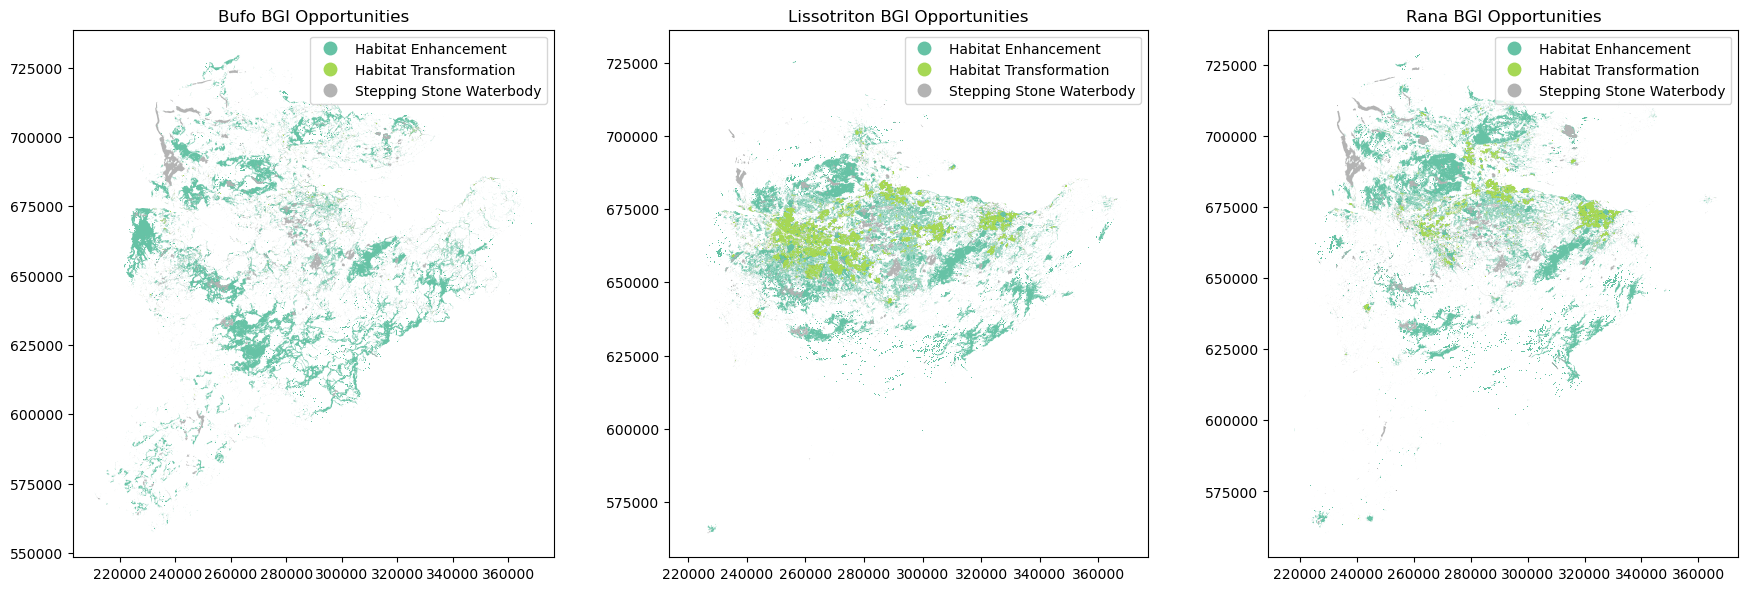

In [10]:
import matplotlib.pyplot as plt

# Load and plot BGI results
fig, axes = plt.subplots(1, len(species_list), figsize=(18, 6))

for i, species in enumerate(species_list):
    ax = axes[i]
    ax.set_title(f"{species} BGI Opportunities")

    bgi_file = f"C:/GIS_Course/MScThesis-MaviSantarelli/results/BGI_Opportunities/{species}_BGI_Opportunities.shp"
    
    if os.path.exists(bgi_file):
        bgi_gdf = gpd.read_file(bgi_file)
        bgi_gdf.plot(ax=ax, column="BGI_Type", legend=True, cmap="Set2")
    else:
        print(f"⚠️ Missing BGI file for {species}, skipping visualization.")

plt.tight_layout()
plt.show()


#### 2. Generate Folium Maps

In [7]:
import folium
import geopandas as gpd
import json
import os

# Define file paths
species_list = ["Bufo", "Lissotriton", "Rana"]
bgi_output_path = "C:/GIS_Course/MScThesis-MaviSantarelli/results/BGI_Opportunities"

# Define colors for each category
bgi_colors = {
    "Habitat Enhancement": "green",
    "Habitat Transformation": "red",
    "Stepping Stone Waterbody": "blue"
}

# Function to create a separate map for each species
def create_species_map(species):
    file_path = f"{bgi_output_path}/{species}_BGI_Opportunities.shp"
    if not os.path.exists(file_path):
        print(f"⚠️ Missing BGI file for {species}, skipping visualization.")
        return

    # Load shapefile
    gdf = gpd.read_file(file_path).to_crs(epsg=4326)  # Convert to WGS84 for folium

    # Create a map centered around the study area
    m = folium.Map(location=[56.0, -3.5], zoom_start=10, tiles="cartodb positron")

    # Convert to GeoJSON
    geojson_data = json.loads(gdf.to_json())

    # Add to map
    folium.GeoJson(
        geojson_data,
        name=f"{species} BGI",
        style_function=lambda feature: {
            "fillColor": bgi_colors.get(feature["properties"]["BGI_Type"], "black"),
            "color": "black",
            "weight": 0.5,
            "fillOpacity": 0.6
        },
        tooltip=folium.GeoJsonTooltip(fields=["BGI_Type"], aliases=["BGI Category"])
    ).add_to(m)

    # Save the map
    output_file = f"{bgi_output_path}/{species}_BGI_Map.html"
    m.save(output_file)
    print(f"✅ Map saved: {output_file}")

# Generate separate maps for each species
for species in species_list:
    create_species_map(species)


✅ Map saved: C:/GIS_Course/MScThesis-MaviSantarelli/results/BGI_Opportunities/Bufo_BGI_Map.html
✅ Map saved: C:/GIS_Course/MScThesis-MaviSantarelli/results/BGI_Opportunities/Lissotriton_BGI_Map.html
✅ Map saved: C:/GIS_Course/MScThesis-MaviSantarelli/results/BGI_Opportunities/Rana_BGI_Map.html


### Step 6: Interpretation and Reporting

## Overview
This phase of the study assessed the overlap between **amphibian connectivity corridors** and **urban features** (green, grey, and blue areas). The goal was to identify where **habitat enhancement** or **transformation** can improve amphibian movement across urban landscapes.

### Key Findings:
| **Species**  | **Green Areas (Habitat Enhancement %)** | **Grey Areas (Habitat Transformation %)** | **Blue Areas (Stepping Stones %)** |
|-------------|-----------------------------------|----------------------------------|-------------------------------|
| **Bufo**        | **High (~52%)**                          | **Moderate (~34%)**                          | **Low (~14%)**                         |
| **Lissotriton** | **Moderate (~40%)**                          | **Very High (~50%)**                          | **Low (~10%)**                         |
| **Rana**        | **High (~48%)**                          | **High (~43%)**                          | **Low (~9%)**                         |

### **Interpretation**
1. **High overlap with Green Areas (Parks/Gardens)**
   - Suggests that **Bufo and Rana already have some connectivity via green spaces**.
   - Lissotriton shows **lower green connectivity**, meaning potential habitat fragmentation.

2. **Very High overlap with Grey Areas (Urban Impervious Surfaces)**
   - **Lissotriton (~50%) is the most affected species**, suggesting severe fragmentation due to roads and buildings.
   - **Bufo and Rana (~34–43%) still face significant urban barriers**.

3. **Low overlap with Blue Areas (Stepping Stones)**
   - Suggests that **water bodies are not playing a major role in connectivity**.
   - There is **potential for wetland restoration or artificial pond creation** to **improve stepping-stone movement**.

Roads act as **physical barriers**, further breaking connectivity.  
To account for this the study could:
1. **Re-run the overlay analysis while splitting corridors at road intersections.**
2. **Compare the connectivity loss due to road fragmentation.**
3. **Identify areas where mitigation (e.g., green bridges or tunnels) may be necessary.**


## Next Steps: Alternative Resistance Scaling in Connectivity Models

To **test the effect of different resistance assumptions**, the study will:
1. **Reclassify resistance using alternative scaling methods:**
   - **Linear** (gradual increase in resistance)
   - **Exponential** (strong barriers for unsuitable areas)
   - **Logarithmic** (weaker barriers for suboptimal areas)
   - **Inverse** (favoring certain habitat types over others)
   
2. **Re-run Circuitscape for each resistance scenario** to see how corridor maps change.
3. **Overlay the new corridor maps with urban features** and re-run the BGI analysis.
4. **Compare results across different resistance assumptions**.
